# Predicting Car Auction Prices Using ML

This notebook presents a predictive modeling project focused on predicting the resale prices of second-hand cars in Myanmar.  The dataset used in this project has undergone some modifications to safeguard data confidentiality of the original dataset.

Within this notebook, we will delve into the comprehensive process of exploring a multi-linear regression model and random forest model for the purpose of predicting used car prices. Our analysis will encompass 

1. Exploratory Data Analysis (EDA)
2. Feature Engineering
3. Model Evaluation
4. Final Model Selection

The objectives of the project are to understand the factors that influence the second-hand car prices in Myanmar and to deliver initial pricing predictions to develop a car auction platform.

## 1. EDA

In [2]:
#Loading necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

#To surpress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_palette('Set2')

In [5]:
used_cars.head()

,car_id,year,car_brand,car_make,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price_mmk,price_usd
0,1,2007,toyota,belta,1.3,170,others,rhd,auto,petrol,Sedan,"15,500,000","11,071"
1,2,2009,toyota,belta,1.3,90,others,rhd,auto,petrol,Sedan,"18,500,000","13,214"
2,3,2007,toyota,belta,1.3,130,others,rhd,auto,petrol,Sedan,"16,500,000","11,786"
3,4,2007,toyota,belta,1.3,100,others,rhd,auto,petrol,Sedan,"16,000,000","11,429"
4,5,2012,toyota,belta,1.0,100,others,rhd,auto,petrol,Sedan,"14,300,000","10,214"


In [6]:
#checking data types

used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_id               500 non-null    int64  
 1   year                 500 non-null    int64  
 2   car_brand            500 non-null    object 
 3   car_make             500 non-null    object 
 4   engine_power         500 non-null    float64
 5   mileage_thousand_km  500 non-null    int64  
 6   colour               500 non-null    object 
 7   steering_position    500 non-null    object 
 8   transmission         500 non-null    object 
 9   fuel_type            500 non-null    object 
 10  body_type            500 non-null    object 
 11  price_mmk            500 non-null    object 
 12  price_usd            500 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 50.9+ KB


In [7]:
#Checking missing values

used_cars.isnull().sum()

car_id                 0
year                   0
car_brand              0
car_make               0
engine_power           0
mileage_thousand_km    0
colour                 0
steering_position      0
transmission           0
fuel_type              0
body_type              0
price_mmk              0
price_usd              0
dtype: int64

Observations:

1. It is more effective to transform the "year" (the year the car was manufactured) to "age" as the "year" alone does not provide any insights.
2. We can also drop one of the price features as it is redundant. Since "USD" is a global currency, we will keep the price_usd feature.


In [8]:
used_cars = (used_cars
        .assign(year = 2019 - used_cars['year']) #since the data was collected in 2019
        .rename(columns = {'year': 'age','price_usd':'price'})
        .drop(['car_id','price_mmk'],axis = 1)
)

used_cars.head()

,age,car_brand,car_make,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price
0,12,toyota,belta,1.3,170,others,rhd,auto,petrol,Sedan,"11,071"
1,10,toyota,belta,1.3,90,others,rhd,auto,petrol,Sedan,"13,214"
2,12,toyota,belta,1.3,130,others,rhd,auto,petrol,Sedan,"11,786"
3,12,toyota,belta,1.3,100,others,rhd,auto,petrol,Sedan,"11,429"
4,7,toyota,belta,1.0,100,others,rhd,auto,petrol,Sedan,"10,214"


In [9]:
# price feature appears as string data because of commas
# change the price_usd into integer datatype by removing commas and trailing spaces

used_cars["price"] = (used_cars["price"]
    .str.replace(',','')
    .str.strip()
    .astype("int")
)

In [10]:
used_cars.describe()

,age,engine_power,mileage_thousand_km,price
count,500.000000,500.000000,500.000000,500.000000
mean,12.582000,1.911440,110.908000,17749.788000
std,4.957866,0.814889,46.732595,7537.223367
min,0.000000,0.660000,5.000000,4857.000000
25%,9.000000,1.300000,90.000000,12357.000000
50%,13.000000,1.800000,100.000000,16071.000000
75%,16.000000,2.400000,140.000000,22553.500000
max,24.000000,4.900000,300.000000,53214.000000


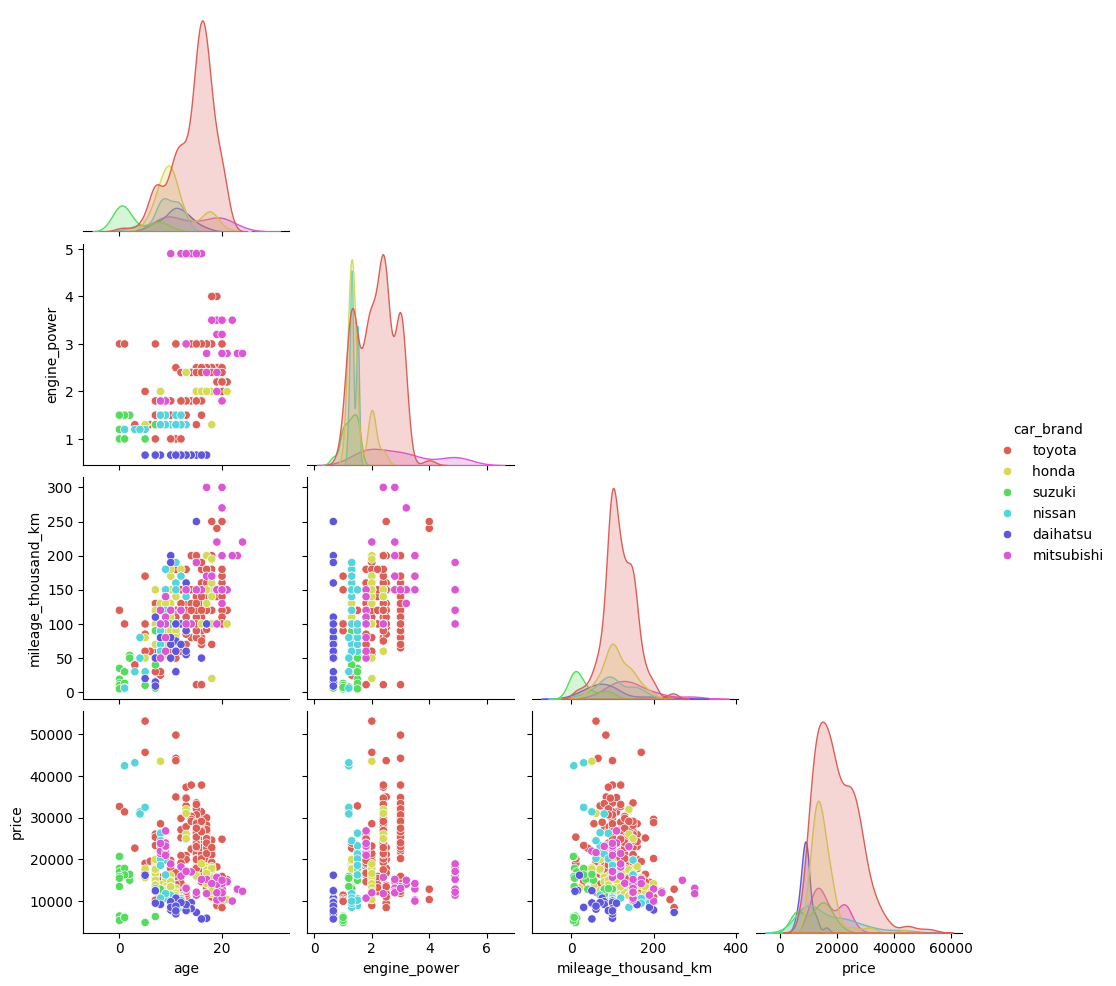

In [9]:
sns.pairplot(used_cars, corner = True, hue = 'car_brand', palette = 'hls')

Based on the pairplots alone, we find that:

- Surprisingly, price doesn't have clear correlation with any of the numeric features. However, the car brand seems to have influences on the price changes. For example, toyota cars are clustered around the higher price range regardless of the age of the cars. Toyota brand also makes up the majority of data distribution.

- The data are also positively skewed. We might need to do data transformation for linear regression.

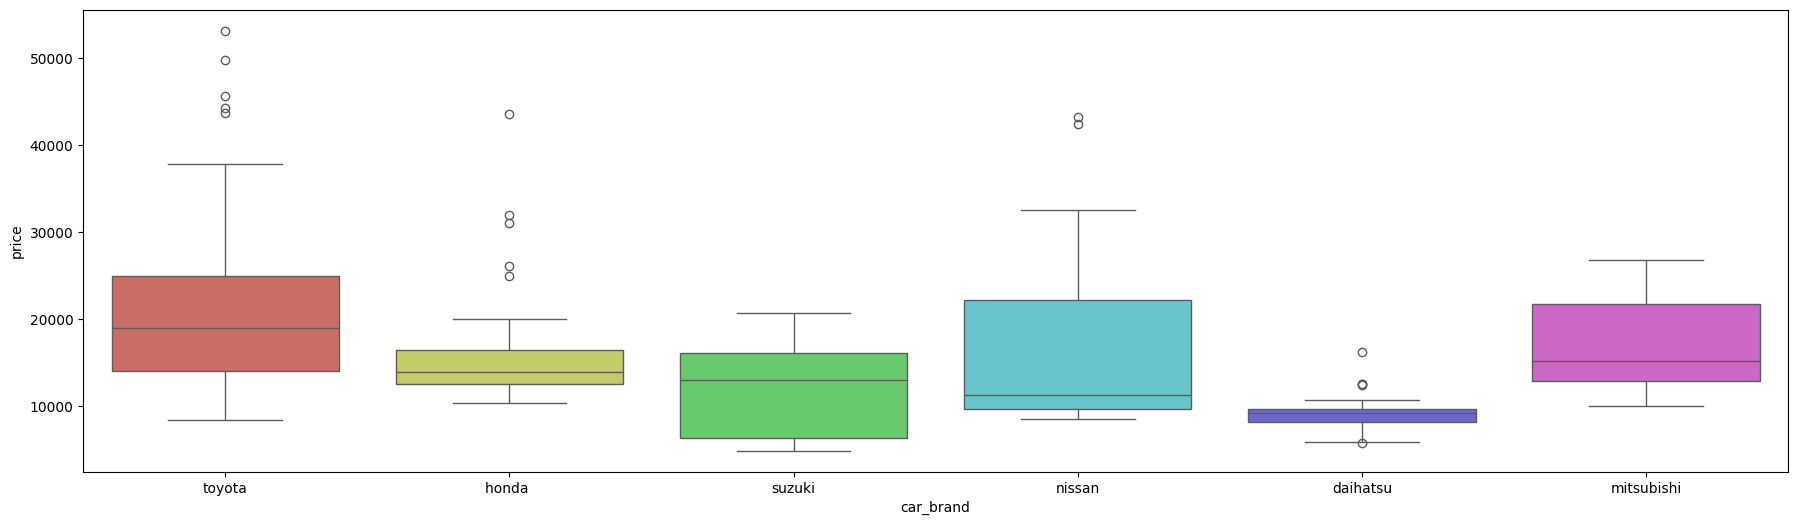

In [11]:
plt.figure(figsize = (22,6))
ax = sns.boxplot(data = used_cars, x = 'car_brand', y= 'price', palette = 'hls')

There are some outliers particularly in toyota and honda brands. We will try without removing outliers first.

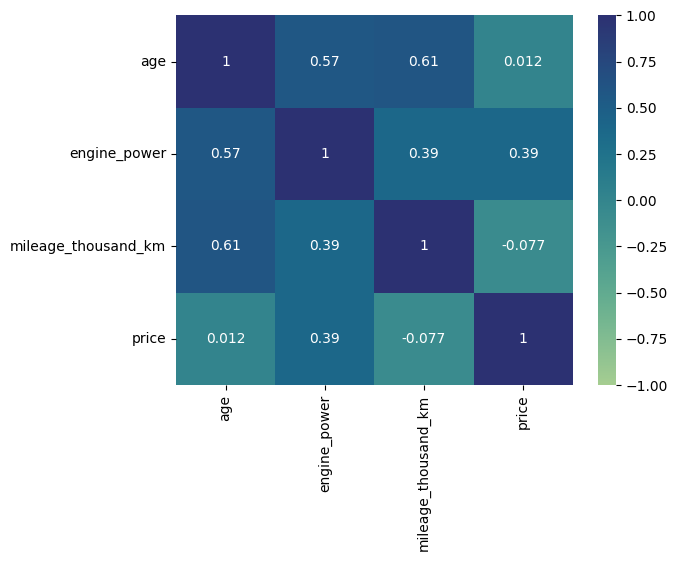

In [12]:
#Checking target-feature relationship and feature-feature relationships

sns.heatmap(
    used_cars.corr(numeric_only = True),
    vmin = -1,
    vmax = 1,
    cmap = 'crest',
    annot = True
);

Similar to observations from pairplots, the strength of correlation between price and age, mileage and price is quite low.

It seems that there is some non-linear relationship.

Some multicollinearity is detected between age and mileage. The older the car is, the higher the mileage is. 

In [16]:
import matplotlib.colors as mcolors
import plotly.express as px

palette = sns.color_palette('hls', 6)
hex_colors = [mcolors.to_hex(color) for color in palette]
color_map = dict(zip(['toyota', 'honda', 'suzuki', 'nissan', 'daihatsu', 'mitsubishi'], hex_colors))

fig = px.scatter_3d(used_cars, x='age', y='engine_power', z='price',
                    color = 'car_brand',
                    color_discrete_map = color_map,
                    title='Used Car Prices vs Age and Engine Power')
fig.update_layout(scene=dict(
                    xaxis_title='Age',
                    yaxis_title='Engine Power',
                    zaxis_title='Price (USD)'))
fig.show()

- As we can see, the relationship between price and the features is not linear due to the lack of clear patterns. 

- Moreover, we observe some interaction effects and clustering within sub-groups.For instance, newer Mitsubishi brands (low age) and higher engine power have tend to have slightly higher prices than other Mistubishi cars. But we can't tell which feature has more influences on the prices from the chart. 

From these observations, models like random forest might be more beneficial considering non-linearity issues. However, we will try with simple linear regression model first as a baseline model by perfoming feature engineering.

In [13]:
#Checking the frequency of categorical values

def value_count(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
        
value_count(used_cars)


car_brand
toyota        280
honda          80
nissan         40
mitsubishi     40
suzuki         30
daihatsu       30
Name: count, dtype: int64
car_make
belta          35
alphard        35
mark 2         35
corolla        35
crown          35
kluger         35
harrier        35
wish           35
insight        30
fit            30
hijet          30
ad_van         22
cr-v           20
pajero         17
juke           13
rvr            13
carry          10
swift          10
ertiga         10
fuso canter    10
qashqai         5
Name: count, dtype: int64
colour
white     209
others    173
black      88
silver     30
Name: count, dtype: int64
steering_position
rhd    472
lhd     28
Name: count, dtype: int64
transmission
auto         374
semi auto     89
manual        37
Name: count, dtype: int64
fuel_type
petrol    478
diesel     22
Name: count, dtype: int64
body_type
Sedan       140
SUV         138
Van         132
Truck        50
Mini-Van     40
Name: count, dtype: int64


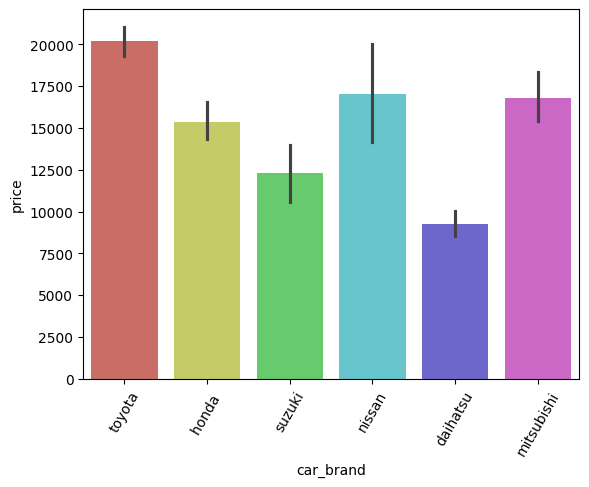

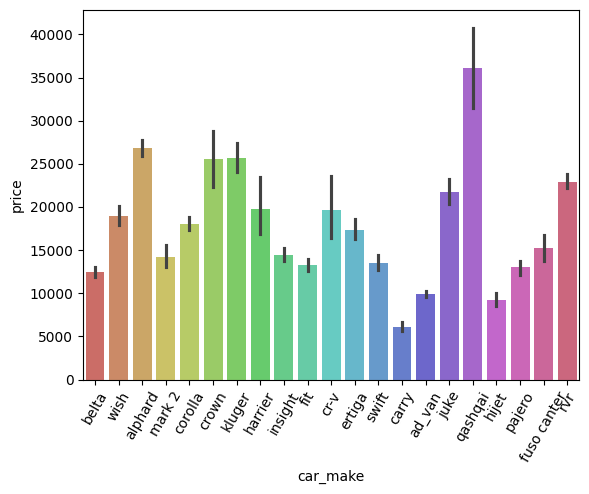

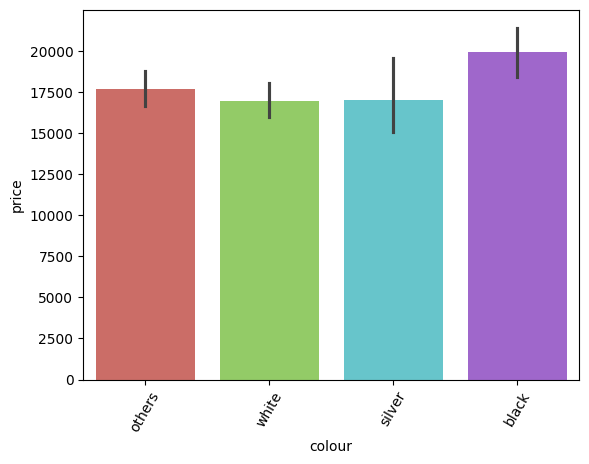

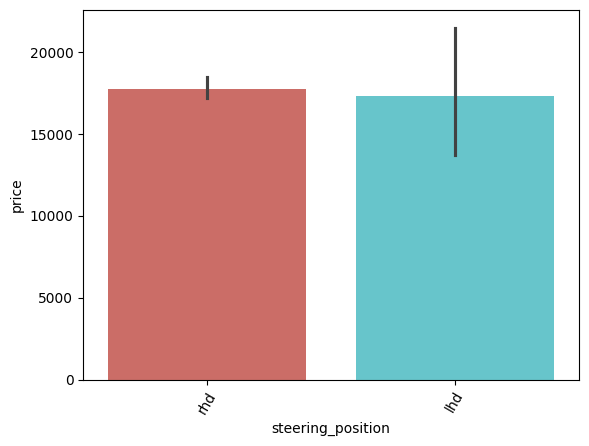

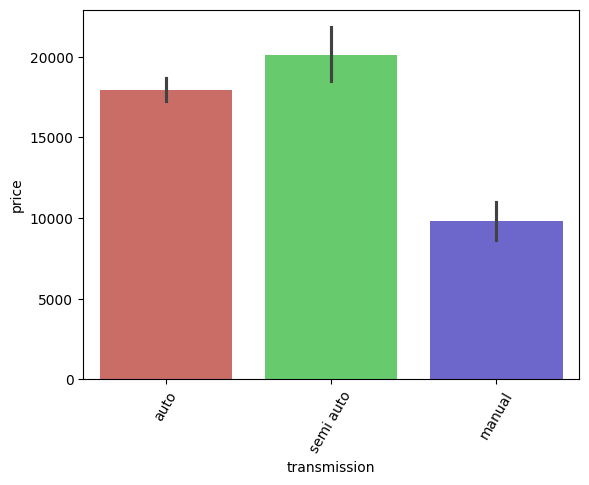

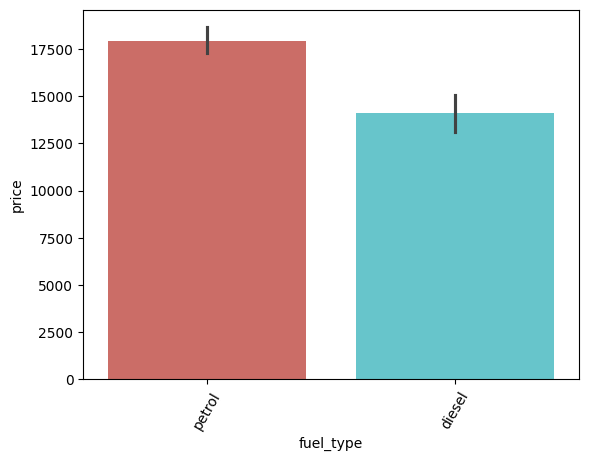

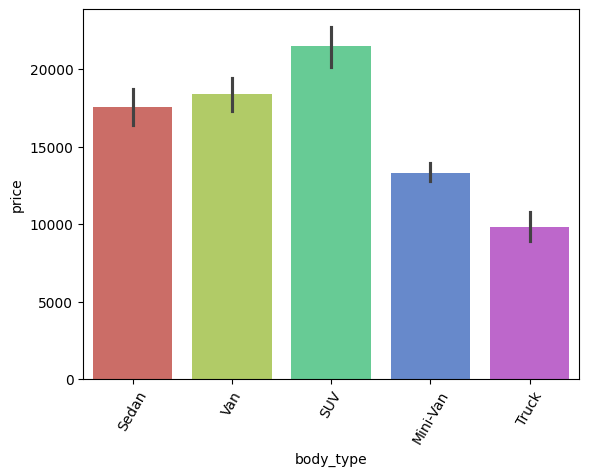

In [14]:
#Checking the price breakdown by the categorical features

def category_plot(dataframe, target):
    for col in dataframe.select_dtypes(["object"]).columns:
        sns.barplot(data = dataframe, x=col, y=target, palette = "hls")
        plt.xticks(rotation = 60)
        plt.show()

category_plot(used_cars, "price")


The samples of the categories are quite imbalanced. 

We should consider combining some features and drop some features.

1. Car brand - Based on price breakdowns, we can recategorise this variable: high-end brands (Toyota), mid-range brands (Honda,Nissan,Mitsubishi), low-end brands (Suzuki, Daihatsu)
   In Myanmar, Toyota has traditionally been a dominant player in the automotive market so Toyota being the majority of samples    makes sense
2. Car make - The price gaps appear to be significant between different car makes. As it has several categories, we can try regularisation to mitigate this. One thing to note is that the make Qashqai has the lowest samples with the highest average car price. The error bar shows the variance of that particular model is also large possibly due to unrepresentative sample. This can potentially influence the model's performance. We will examine the model first without removing that car make.
3. Colour - Black cars seem to be more expensive. So, we can recategorise: "black" and "non-black"
4. Steering Position - Right hand drive makes up the vast majority of the samples. (This also aligns with the Myanmar market given the left hand drive cars were introduced to the market only recently). There is no price difference between the two as well. So, we can drop this feature as it does not add any additional insight
5. Transmission - We can combine "semi-auto" and manual into "non-auto"
6. Fuel Type - although "diesel" types have few samples, there seems to be a significant price difference.
6. Body type - We can combine "Van" and "Mini-van" into one category.


## 2. Feature Engineering

In [15]:
car_brand_map = {
    "toyota" : "high_end_brands",
    "honda" : "mid_range_brands",
    "nissan" : "mid_range_brands",
    "mitsubishi" : "mid_range_brands",
    "suzuki" : "low_end_brands",
    "daihatsu" : "low_end_brands"
}

car_make_map = {
    "belta"  : "belta", 
    "alphard" : "alphard",
    "mark 2" : "mark 2",
    "corolla" : "corolla",
    "crown"  :  "crown",
    "kluger" : "kluger",
    "harrier" : "harrier",
    "wish" : "wish",
    "insight" : "insight",
    "fit" : "fit",
    "hijet" : "hijet",
    "ad_van" : "ad_van",
    "cr-v" : "cr-v",
    "pajero" : "pajero",
    "juke" : "juke",
    "rvr" :  "rvr",
    "carry" : "other",
    "swift" : "other",
    "ertiga": "other",
    "fuso canter" : "other",
    "qashqai" : "qashqai"
}


colour_map = {
    "black" : "black",
    "others" : "non_black",
    "white" :"non_black",
    "silver" : "non_black"
}

transmission_map = {
    "auto" : "auto",
    "semi auto" : "non_auto",
    "manual" : "non_auto"
}

In [16]:
#Creating a new dataframe for feature engineering

used_cars_eng = (
    pd.get_dummies(
        used_cars.assign(
            car_brand = used_cars["car_brand"].map(car_brand_map),
            car_make = used_cars["car_make"].map(car_make_map),
            colour = used_cars["colour"].map(colour_map),
            transmission = used_cars["transmission"].map(transmission_map),
            engine_power2 = used_cars["engine_power"] ** 2,
            engine_power3 = used_cars["engine_power"] ** 3,
            mileage2 = used_cars["mileage_thousand_km"] ** 2,
            mileage3 = used_cars["mileage_thousand_km"] ** 3
        ).drop(["steering_position"],axis =1),
        drop_first = True,
        dtype = int
    )
)

used_cars_eng.head()
                

,age,engine_power,mileage_thousand_km,price,engine_power2,engine_power3,mileage2,mileage3,car_brand_low_end_brands,car_brand_mid_range_brands,...,car_make_qashqai,car_make_rvr,car_make_wish,colour_non_black,transmission_non_auto,fuel_type_petrol,body_type_SUV,body_type_Sedan,body_type_Truck,body_type_Van
0,12,1.3,170,11071,1.69,2.197,28900,4913000,0,0,...,0,0,0,1,0,1,0,1,0,0
1,10,1.3,90,13214,1.69,2.197,8100,729000,0,0,...,0,0,0,1,0,1,0,1,0,0
2,12,1.3,130,11786,1.69,2.197,16900,2197000,0,0,...,0,0,0,1,0,1,0,1,0,0
3,12,1.3,100,11429,1.69,2.197,10000,1000000,0,0,...,0,0,0,1,0,1,0,1,0,0
4,7,1.0,100,10214,1.00,1.000,10000,1000000,0,0,...,0,0,0,1,0,1,0,1,0,0


## 3. Model Exploration

### Multi-Linear Regression

In [17]:
from sklearn.model_selection import train_test_split

target = "price"

# To drop features based on model coefficients
drop_cols = [
    "colour_non_black",
    "fuel_type_petrol",
]

X = sm.add_constant(used_cars_eng.drop(["price"] + drop_cols,axis=1))
y = np.log(used_cars_eng["price"])

# Spliting training and test sets

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = .2, random_state = 42)

In [18]:
# Cross-validation

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae


def cross_validation(X,y,n_splits):
    kf = KFold (n_splits = n_splits, shuffle = True, random_state = 2024)
    
    #Storing validation scores 
    cv_train_r2s = []
    cv_train_mae = []
    cv_val_r2s = []
    cv_val_mae =[]
    
    #Loop through cv folds
    for train_ind, val_ind in kf.split(X,y):
        #Subset data based on folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        #Fitting the model on each train
        model = sm.OLS(y_train, X_train).fit()
        #Append training and validation scores to the list
        cv_train_r2s.append(r2(y_train,model.predict(X_train)))
        cv_train_mae.append(mae(np.exp(y_train), np.exp(model.predict(X_train))))
        cv_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_val_mae.append(mae(np.exp(y_val), np.exp(model.predict(X_val),)))
        

        print(f"All training R2s : {[round(x,3) for x in cv_train_r2s]}")
        print(f"Training R2s : {round(np.mean(cv_train_r2s), 3)} +- {round(np.std(cv_train_r2s),3)}")
        
        print(f"All training MAE : {[round(x,3) for x in cv_train_mae]}")
        print(f"Training MAE : {round(np.mean(cv_train_mae), 3)} +- {round(np.std(cv_train_mae),3)}")
        
        print(f"All validation R2s : {[round(x,3) for x in cv_val_r2s]}")
        print(f"Validation R2s : {round(np.mean(cv_val_r2s), 3)} +- {round(np.std(cv_val_r2s),3)}")
        
        print(f"All validation MAEs : {[round(x,3) for x in cv_val_mae]}")
        print(f"Validation MAE : {round(np.mean(cv_val_mae), 3)} +- {round(np.std(cv_val_mae),3)}")
        
        return model
        
model = cross_validation(X,y,5)

All training R2s : [0.855]
Training R2s : 0.855 +- 0.0
All training MAE : [2233.158]
Training MAE : 2233.158 +- 0.0
All validation R2s : [0.829]
Validation R2s : 0.829 +- 0.0
All validation MAEs : [2520.397]
Validation MAE : 2520.397 +- 0.0


In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     77.96
Date:                Fri, 22 Mar 2024   Prob (F-statistic):          4.02e-137
Time:                        17:24:42   Log-Likelihood:                 177.41
No. Observations:                 400   AIC:                            -296.8
Df Residuals:                     371   BIC:                            -181.1
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          8.5684      0.282     30.399      0.000       8.014       9.123
age                           -0.0531      0.004    -14.958      0.000      -0.060      -0.046
engine_power                   0.5903      0.390      1.515      0.131      -0.176       1.357
mileage_thousand_km            0.0035      0.001      2.498      0.013       0.001       0.006
engine_power2                 -0.2368      0.139     -1.705      0.089      -0.510       0.036
engine_power3                  0.0265      0.016      1.660      0.098      -0.005       0.058
mileage2                   -3.085e-05   1.07e-05     -2.880      0.004   -5.19e-05   -9.78e-06
mileage3                    6.037e-08   2.52e-08      2.400      0.017    1.09e-08     1.1e-07
car_brand_low_end_brands      -0.7603      0.188     -4.049      0.000      -1.129      -0.391
car_brand_mid_range_brands     0.6969      0.049     14.137      0.000       0.600       0.794
car_make_alphard               1.9875      0.092     21.513      0.000       1.806       2.169
car_make_belta                -0.1477      0.040     -3.692      0.000      -0.226      -0.069
car_make_corolla               0.1086      0.036      3.016      0.003       0.038       0.179
car_make_cr-v                  0.5699      0.059      9.701      0.000       0.454       0.685
car_make_crown                 0.7737      0.060     12.996      0.000       0.657       0.891
car_make_fit                   0.9231      0.078     11.787      0.000       0.769       1.077
car_make_harrier               0.7370      0.059     12.472      0.000       0.621       0.853
car_make_hijet                 2.2804      0.227     10.030      0.000       1.833       2.727
car_make_insight               0.9594      0.054     17.774      0.000       0.853       1.066
car_make_juke                 -0.5000      0.064     -7.850      0.000      -0.625      -0.375
car_make_kluger                0.8839      0.056     15.897      0.000       0.775       0.993
car_make_mark 2                0.3385      0.055      6.159      0.000       0.230       0.447
car_make_other                 1.4636      0.226      6.463      0.000       1.018       1.909
car_make_pajero               -0.1220      0.069     -1.774      0.077      -0.257       0.013
car_make_qashqai              -0.1557      0.102     -1.523      0.129      -0.357       0.045
car_make_rvr                  -0.3142      0.054     -5.802      0.000      -0.421      -0.208
car_make_wish                  1.4979      0.077     19.531      0.000       1.347       1.649
transmission_non_auto         -0.0929      0.040     -2.342      0.020      -0.171      -0.015
body_type_SUV                  1.0989      0.091     12.094      0.000       0.920       1.278
body_type_Sedan                1.0730      

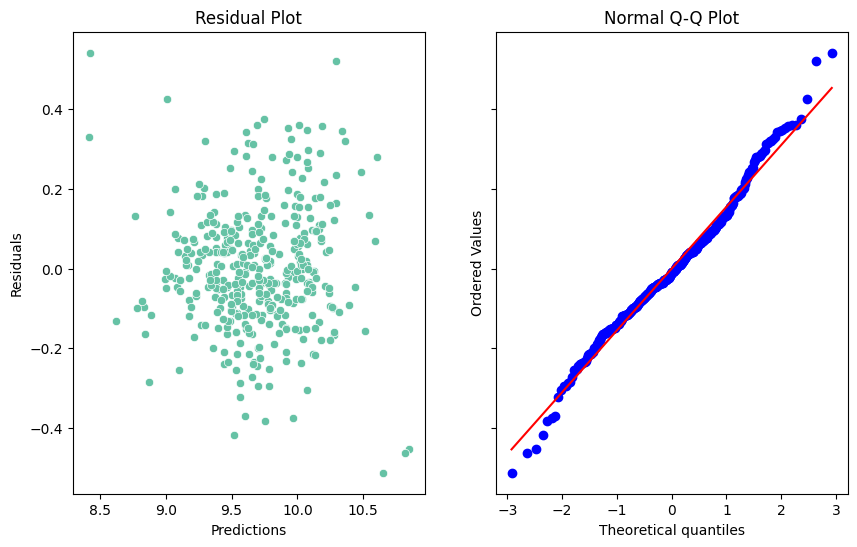

In [20]:
# Checking regression assumptions

def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    resids = model.resid
    
    fig, ax=plt.subplots(1,2, sharey="all", figsize = (10,6))
    
    sns.scatterplot(x=predictions, y=resids, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Predictions")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(resids,dist = "norm", plot = ax[1])
    ax[1].set_title("Normal Q-Q Plot")
    
residual_analysis_plots(model)

In [21]:
#Checking outliers

influence = model.get_influence()
influence_df = influence.summary_frame()
influence_df["cooks_d"].sort_values(ascending= False).head()

479    1.548038
385    0.249425
380    0.053547
179    0.047116
183    0.041321
Name: cooks_d, dtype: float64

Cooks distance scores look okay. However, it is better to investigate these observations to determine whether to remove them or not.

In [22]:
#Creating a dataframe for most influential data points

outliers_df = used_cars.loc[[479,385,179,183,380]]

outliers_df.head()

,age,car_brand,car_make,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price
479,13,mitsubishi,fuso canter,3.00,150,white,rhd,manual,diesel,Truck,13071
385,10,suzuki,carry,0.66,100,others,rhd,auto,petrol,Truck,7857
179,0,toyota,crown,3.00,120,white,rhd,auto,petrol,Sedan,32714
183,1,toyota,crown,3.00,100,black,rhd,auto,petrol,Sedan,31429
380,7,suzuki,carry,0.66,6,white,rhd,manual,petrol,Truck,6286


In [23]:
#Since Fuso Canter has the highest cooks distance, we want to look into this model specifically.

fuso_df = used_cars[used_cars["car_make"] == "fuso canter"]

fuso_df.head(10)

,age,car_brand,car_make,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price
477,15,mitsubishi,fuso canter,4.9,190,white,rhd,manual,diesel,Truck,11429
478,13,mitsubishi,fuso canter,4.9,150,white,rhd,manual,diesel,Truck,12857
479,13,mitsubishi,fuso canter,3.0,150,white,rhd,manual,diesel,Truck,13071
480,12,mitsubishi,fuso canter,4.9,120,white,rhd,manual,diesel,Truck,18214
481,10,mitsubishi,fuso canter,4.9,120,white,rhd,manual,diesel,Truck,18929
482,12,mitsubishi,fuso canter,4.9,120,white,rhd,manual,diesel,Truck,16000
483,16,mitsubishi,fuso canter,4.9,150,others,rhd,manual,diesel,Truck,15214
484,14,mitsubishi,fuso canter,4.9,100,white,rhd,manual,diesel,Truck,17000
485,15,mitsubishi,fuso canter,4.9,150,white,rhd,manual,diesel,Truck,12143
486,13,mitsubishi,fuso canter,4.9,100,white,rhd,manual,diesel,Truck,17143


It seems that the unique engine power of index 479 possibly makes this data point influential on the model. However, as the cooks distance score is less than 1, we will keep it. 

In [24]:
#Checking VIF scores for multi-collinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                            0.000000
age                              5.131565
engine_power                  1762.051053
mileage_thousand_km             69.701235
engine_power2                 5142.833099
engine_power3                 1358.263316
mileage2                       253.178533
mileage3                        83.451725
car_brand_low_end_brands              inf
car_brand_mid_range_brands            inf
car_make_alphard                      inf
car_make_belta                        inf
car_make_corolla                      inf
car_make_cr-v                         inf
car_make_crown                        inf
car_make_fit                          inf
car_make_harrier                      inf
car_make_hijet                  50.148163
car_make_insight                      inf
car_make_juke                         inf
car_make_kluger                       inf
car_make_mark 2                       inf
car_make_other                  67.788650
car_make_pajero                   

Assumptions Evaluation

1. Linearity  - No obvious pattern that violates linearity
2. Independence - Durbin Watson test score between 1.5 and 2.5 is acceptable
3. Normality - Normal Q-Q plot is better after log transformation
4. Multi-collinearity - there are some potential multicollinearity issues. we can try Ridge regularisation to mitigate this.
5. Homoscedasticity - Residuals seem to be scattered randomly with no clear patterns. There is a slight indication that the variance of residuals increase as the predictions increase but it is not very pronounced.

### Regularisation

In [25]:
# Regularisation

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train_std= std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [26]:
# Ridge Model

from sklearn.linear_model import RidgeCV

n_alphas = 100
alphas = 10 ** np.linspace(-3,3,n_alphas)

ridge_model = RidgeCV(alphas = alphas, cv = 5)

ridge_model.fit(X_train_std,y_train)

print(f"Cross Validation R2: {ridge_model.score(X_train_std,y_train)}")
print(f"Cross Validation MAE: {mae(np.exp(y_train), np.exp(ridge_model.predict(X_train_std)))}")
print(f"Alpha value: {ridge_model.alpha_}")

Cross Validation R2: 0.8347728182076769
Cross Validation MAE: 2363.2498806896147
Alpha value: 0.5336699231206312


In [27]:
# Lasso Model

from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = 10 ** np.linspace(-2,3,n_alphas)

lasso_model = LassoCV(alphas = alphas, cv = 5)

lasso_model.fit(X_train_std,y_train)

print(f"Cross Validation R2: {lasso_model.score(X_train_std,y_train)}")
print(f"Cross Validation MAE: {mae(np.exp(y_train), np.exp(lasso_model.predict(X_train_std)))}")
print(f"Alpha value: {lasso_model.alpha_}")

Cross Validation R2: 0.7493001764704283
Cross Validation MAE: 2714.6116685885167
Alpha value: 0.01


In [28]:
#Checking coefficient estimates of features

list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('age', -0.18603359173230824),
 ('engine_power', 0.1470219627233981),
 ('mileage_thousand_km', -0.0),
 ('engine_power2', 0.0),
 ('engine_power3', 0.0),
 ('mileage2', -0.03884071487849011),
 ('mileage3', -0.0),
 ('car_brand_low_end_brands', -0.05170716153109172),
 ('car_brand_mid_range_brands', -0.04885535810288737),
 ('car_make_alphard', 0.11461508544894478),
 ('car_make_belta', -0.03979857943104089),
 ('car_make_corolla', 0.004549084543412047),
 ('car_make_cr-v', -0.0),
 ('car_make_crown', 0.06696358217919575),
 ('car_make_fit', -0.03265228326261919),
 ('car_make_harrier', 0.0),
 ('car_make_hijet', 0.0),
 ('car_make_insight', -0.012681281839203345),
 ('car_make_juke', 0.0002562966774988151),
 ('car_make_kluger', 0.06301274603523527),
 ('car_make_mark 2', 0.0),
 ('car_make_other', -0.06330440228689209),
 ('car_make_pajero', -0.018548110573782625),
 ('car_make_qashqai', 0.037763448922422435),
 ('car_make_rvr', 0.00657734142987026),
 ('car_make_wish', 0.0702171937318233

Since Ridge model outperforms the baseline model, it means that regularisation helps with the mulitcollinearity issue. 

### Random Forest

In [29]:
target = "price"

# To drop features based on model coefficients
drop_cols = [
    "engine_power2",
    "engine_power3",
    "mileage2",
    "mileage3",
    "colour_non_black",
    "fuel_type_petrol",
]

X = used_cars_eng.drop(["price"] + drop_cols,axis=1)
y = used_cars_eng["price"]

# Spliting training and test sets

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = .2, random_state = 42)

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor(n_estimators=100, random_state=42)

#Fit the model
rf_base.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
y_train_pred = rf_base.predict(X_train)

print(f"Train R2: {r2(y_train,y_train_pred)}")
print(f"Train MAE: {mae(y_train,y_train_pred)}")

Train R2: 0.9575590502801552
Train MAE: 1026.1081361472209


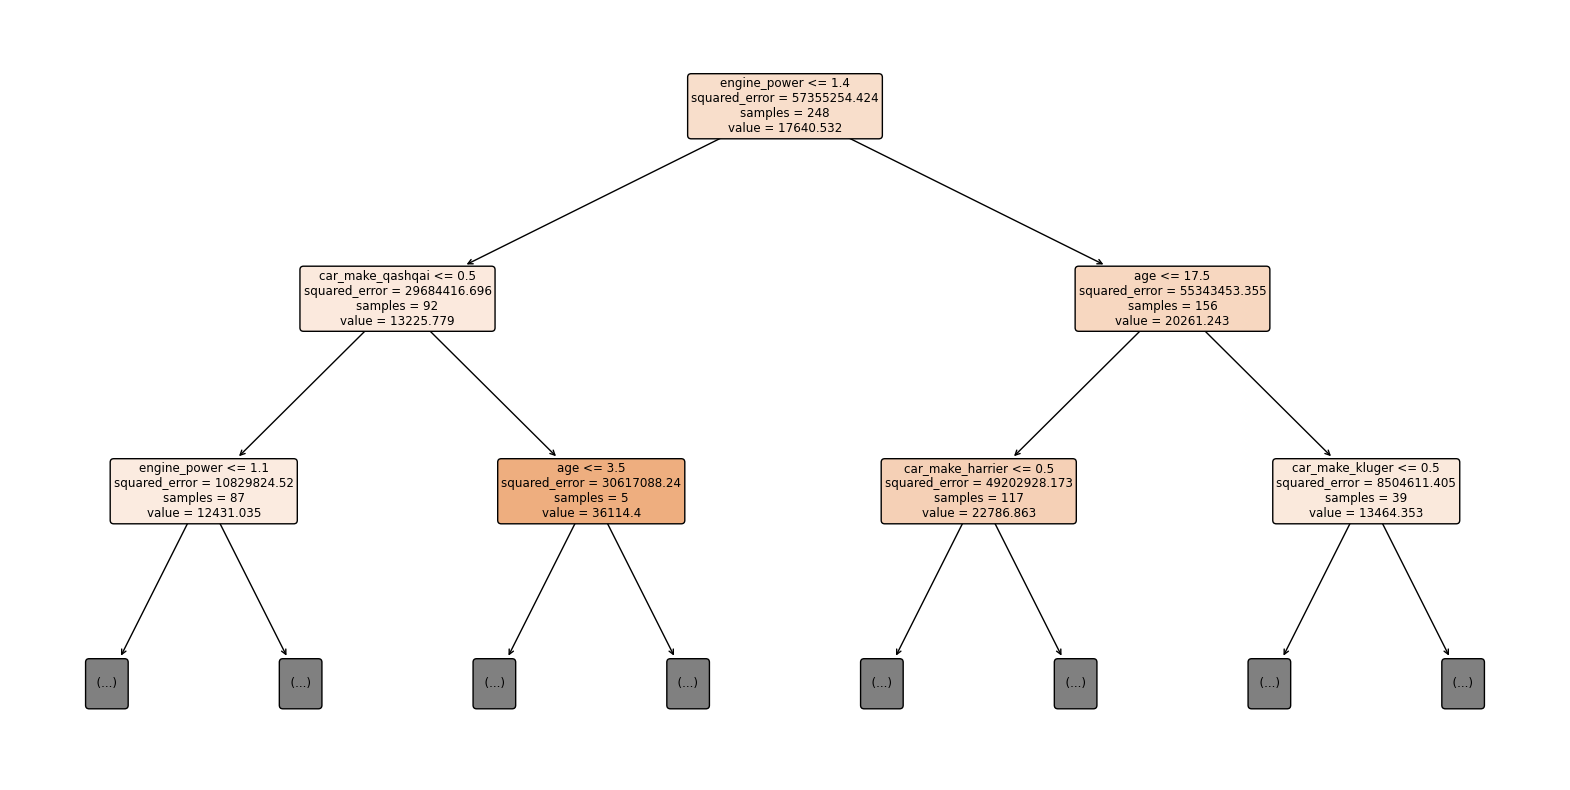

In [32]:
#Visualise the first tree in random forest

from sklearn.tree import plot_tree

plt.figure(figsize = (20,10))

plot_tree(rf_base.estimators_[0],
          feature_names = X_train.columns,
          rounded = True,
          max_depth = 2,
          filled = True)
plt.yticks(fontsize = 14)
plt.show()

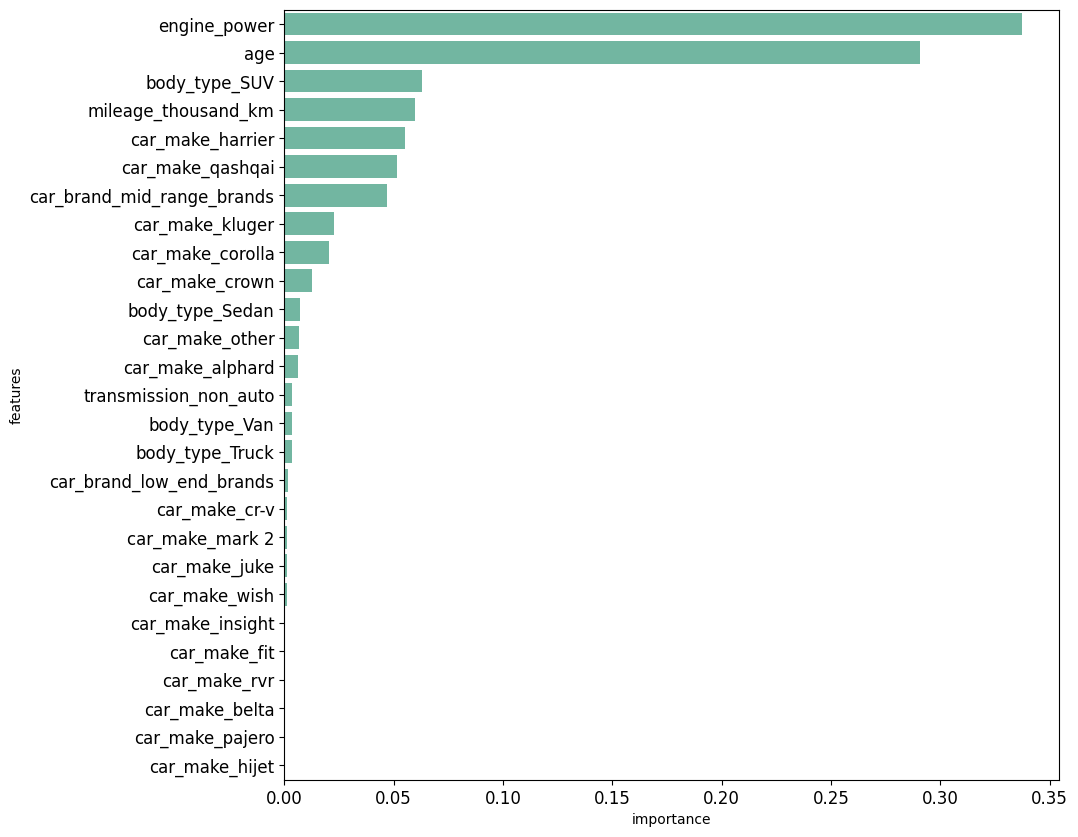

In [33]:
feature_importance = (
    pd.DataFrame({
        'features' : X_train.columns,
        'importance' : rf_base.feature_importances_
    })
    .sort_values('importance', ascending = False)
)


fig, ax = plt.subplots(figsize = (10,10))

sns.barplot(feature_importance,x = 'importance', y = 'features')

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.show()


The model has potential overfitting issues considering high R2.

In [34]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = 42)

params = {
    'n_estimators' : np.arange(start = 100, stop = 500, step = 50),
    'max_features': [None, "sqrt"],
    'max_samples': [None, .3, .5, .9],
    'max_depth': np.arange(start=1, stop=15, step=1),
    'min_samples_leaf': [2, 5, 10, 20, 100],
}

rs = RandomizedSearchCV(
    rf,
    params,
    n_iter = 100,
    scoring = 'neg_mean_absolute_error'
)

rs.fit(X_train,y_train)

print(rs.best_score_)
print(rs.best_params_)

-2279.822852315969
{'n_estimators': 100, 'min_samples_leaf': 2, 'max_samples': 0.9, 'max_features': None, 'max_depth': 6}


In [36]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state = 42)

params_gs = {
    'n_estimators' : np.arange(start = 50, stop = 200, step = 10),
    'min_samples_leaf' : [2,3,4],
    'max_samples' : [0.8,0.9,0.10],
    'max_features' : [None],
    'max_depth' : [5]
}

gs = GridSearchCV(
    rf,
    params_gs,
    scoring = 'neg_mean_absolute_error'
)

gs.fit(X_train,y_train)

print(gs.best_score_)
print(gs.best_params_)

-2240.734431133335
{'max_depth': 7, 'max_features': None, 'max_samples': 0.9, 'min_samples_leaf': 2, 'n_estimators': 80}


In [44]:
params = {
    'max_depth': 7, 
    'max_features': None, 
    'max_samples': 0.9, 
    'min_samples_leaf': 2, 
    'n_estimators': 80
}

rf_tuned = RandomForestRegressor(random_state = 42, **params)

rf_tuned.fit(X_train, y_train)

y_train_pred_tuned = rf_tuned.predict(X_train)

print(f"Train R2: {r2(y_train,y_train_pred_tuned)}")
print(f"Train MAE: {mae(y_train,y_train_pred_tuned)}")

Train R2: 0.8921789478432641
Train MAE: 1624.9392033092238


Out of all the CV scores, random forest performs the best. So, we'll fit the test set with the final random forest model. 

## Final Model Selection

In [45]:
final_model= rf_tuned.fit(X_train,y_train)

print(f"R2: {r2(y_test,final_model.predict(X_test))}")
print(f"MAE: {mae(y_test,final_model.predict(X_test))}")

R2: 0.8342767047178297
MAE: 1921.3376066791475
